There has been is a surge in the number of people making purchases online in recent years (Sakar et. al, 2018). Different from traditional retailing, where the salesperson gain experience and can apply sales approaches tailored to each individual costumer; online shopping lacks customised consumer experience, which can result in several virtual cart abandonments, and purchase conversion rates are not reaching their optimum levels.  

In order to improve costumer experience, it is important to detect and make behavioural predictions, so that the virtual shopping environment can be optimised to replicate the conversion rates of a salesperson. 

In [212]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

import seaborn as sns

import itertools

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report, precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# from deslib.static.stacked import StackedClassifier

from vecstack import stacking

import warnings
warnings.filterwarnings('ignore')


# DATA PREP

In [213]:
raw_df = pd.read_csv('online_shoppers_intention.csv')

In [214]:
raw_df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [215]:
raw_df['Revenue'].value_counts()

False    10422
True      1908
Name: Revenue, dtype: int64

Things to look at:
* SMOTE
* Bagging, boosting and stacking and Voting
* Logistic regression
* Decision Tree
* Random Forest
* SVM
* PCA
* Clustering


In [216]:
raw_df['VisitorType'].value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [217]:
# removing the 'Other' category from 'VisitorType'
df = raw_df.set_index('VisitorType')
df = df.drop(['Other'], axis=0)
df = df.reset_index()
print(df['VisitorType'].value_counts())

df_vt = pd.get_dummies(df['VisitorType'])
df = df.merge(df_vt, left_index = True, right_index=True)

df_w = pd.get_dummies(df['Weekend'])
df = df.merge(df_w, left_index = True, right_index=True)

df_r = pd.get_dummies(df['Revenue'])
df = df.merge(df_r, left_index = True, right_index=True)

df = df.drop(['VisitorType', 'Returning_Visitor', 'Weekend', 'Revenue', 'False_x', 'False_y'], axis=1)
df = df.rename(columns={"True_x": "Weekend", "True_y": "Revenue"})

month = {'Feb':2, 'Mar':3, 'May':5, 'Oct':10, 
         'June':6, 'Jul':7, 'Aug':8, 'Nov':11, 
         'Sep':9, 'Dec':12}
df.Month = [month[item] for item in df.Month]

Returning_Visitor    10551
New_Visitor           1694
Name: VisitorType, dtype: int64


In [218]:
df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,New_Visitor,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,1,1,1,1,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,2,2,2,1,2,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,2,4,1,9,3,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,2,3,2,2,4,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,2,3,3,1,4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12240,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,12,4,6,1,1,0,1,0
12241,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,11,3,2,1,8,0,1,0
12242,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,11,3,2,1,13,0,1,0
12243,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,11,2,2,3,11,0,0,0


In [219]:
y = df['Revenue']
X = df[['Administrative','Administrative_Duration',
        'Informational', 'Informational_Duration', 
        'ProductRelated', 'ProductRelated_Duration', 
        'BounceRates', 'ExitRates','PageValues',
        'SpecialDay','Month','OperatingSystems','Browser',
        'Region', 'TrafficType', 'Weekend']]


In [220]:
# SMOTE - to correct for imbalanced class
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_resampled, y_resampled = smote.fit_sample(X, y) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_resampled).value_counts()) 

Original class distribution: 

0    10353
1     1892
Name: Revenue, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    10353
0    10353
Name: Revenue, dtype: int64


In [221]:
X_resampled

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,Weekend
0,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,2,1,1,1,1,0
1,0,0.000000,0,0.000000,2,64.000000,0.000000,0.100000,0.000000,0.000000,2,2,2,1,2,0
2,0,0.000000,0,0.000000,1,0.000000,0.200000,0.200000,0.000000,0.000000,2,4,1,9,3,0
3,0,0.000000,0,0.000000,2,2.666667,0.050000,0.140000,0.000000,0.000000,2,3,2,2,4,0
4,0,0.000000,0,0.000000,10,627.500000,0.020000,0.050000,0.000000,0.000000,2,3,3,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20701,1,36.665065,3,145.337479,20,551.192215,0.000000,0.007071,29.976123,0.000000,10,1,1,3,1,0
20702,0,0.000000,0,0.000000,8,457.354309,0.000000,0.025959,26.475036,0.000000,7,1,2,2,2,0
20703,0,0.000000,0,0.000000,28,514.534162,0.006602,0.013469,1.576599,0.000000,7,2,2,6,1,0
20704,0,0.000000,0,0.000000,22,450.789034,0.003032,0.023275,0.000000,0.000000,11,1,2,3,2,0


As our target class is quite imbalanced (roughly 80-20 split) we applied SMOTE to our data in order to work on a balanced dataset

# EDA

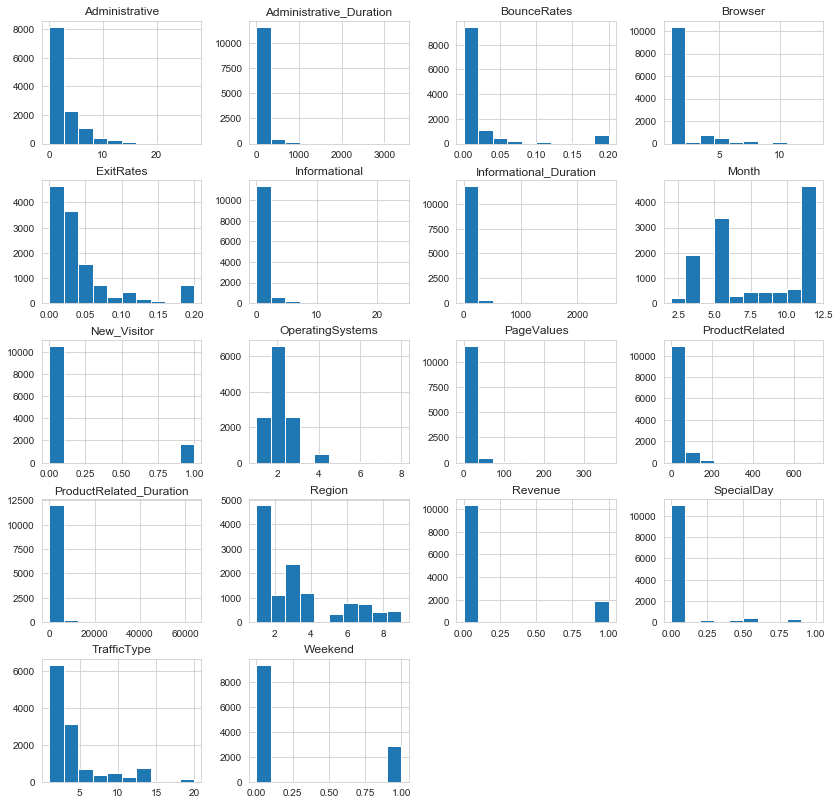

In [222]:
df[df.describe().columns].hist(figsize=(14,14));

In [223]:
df.SpecialDay.value_counts()

0.0    10994
0.6      351
0.8      325
0.4      243
0.2      178
1.0      154
Name: SpecialDay, dtype: int64

Special Day is a categorical variable as it has 6 specific values

In [224]:
non_num_cols = list(set(raw_df.columns) - set(raw_df.describe().columns))
print('Non-numerical features: ',non_num_cols)

Non-numerical features:  ['Revenue', 'VisitorType', 'Month', 'Weekend']


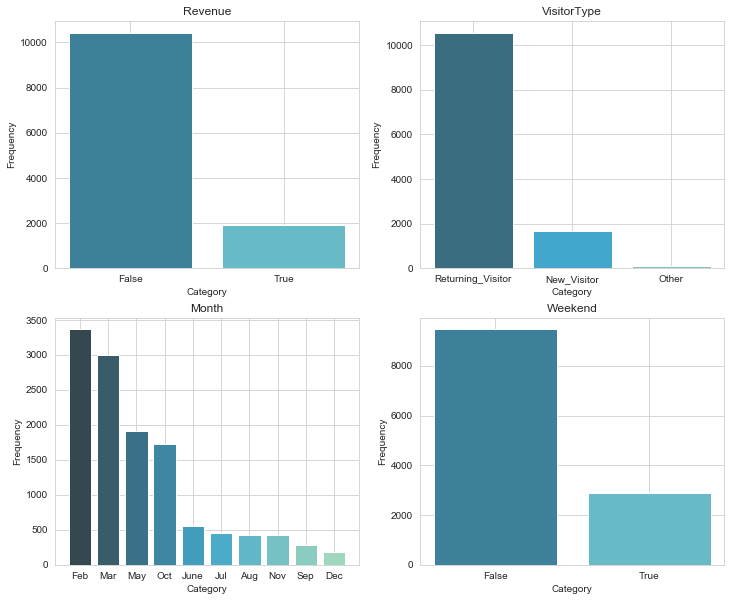

In [225]:
fig, axs = plt.subplots(2, 2,figsize=(12,10))
#Create a bar chart for each of the non-numerical variables.
for i, col in enumerate(non_num_cols):
    #Helper variables to assign the correct axes to each of the 4 plots.
    j=i//2
    k=i%2
    #Setting a color palette for the plots.
    color = sns.color_palette("GnBu_d",n_colors=len(raw_df[col].unique()))
    #Create the bar plot.
    axs[j,k].bar(raw_df[col].astype('str').unique(), raw_df[col].value_counts(), color= color)
    axs[j,k].set_title(col)
    axs[j,k].set_ylabel('Frequency')
    axs[j,k].set_xlabel('Category')
plt.show();

In [226]:
print(df.New_Visitor.value_counts(),'\n')
print('''Number of revenue generating users as VisitorType 'Other': ''',
      df[df['New_Visitor']=='Other'][df['Revenue']==True].Revenue.count())

0    10551
1     1694
Name: New_Visitor, dtype: int64 

Number of revenue generating users as VisitorType 'Other':  0


0    84.55
1    15.45
Name: Revenue, dtype: float64


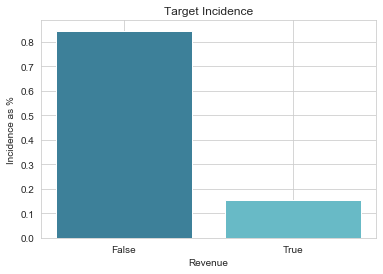

In [227]:
print(round(df.Revenue.value_counts(normalize=True),4)*100)
plt.bar(['False','True'], df.Revenue.value_counts(normalize=True), color=sns.color_palette("GnBu_d",n_colors=2))
plt.title('Target Incidence')
plt.ylabel('Incidence as %')
plt.xlabel('Revenue')
plt.show();

1    38.97
3    19.56
4     9.61
2     9.24
6     6.57
7     6.20
9     3.72
8     3.54
5     2.60
Name: Region, dtype: float64


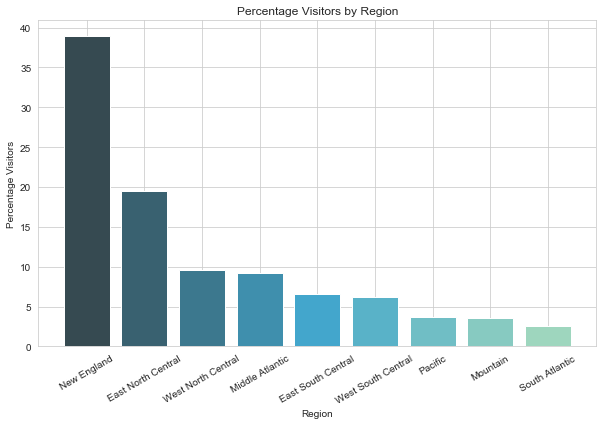

In [228]:
regional_revenue = df[['Region','Revenue']]
regional_revenue = regional_revenue.replace(to_replace=[1, 2,3,4,5,
                                                        6,7,8,9],value=['New England','Middle Atlantic',
                                                                        'East North Central',
                                                                        'West North Central','South Atlantic',
                                                                        'East South Central',
                                                                        'West South Central',
                                                                        'Mountain','Pacific'])
print(round(df.Region.value_counts(normalize=True),4)*100)
plt.figure(figsize=(10,6))
plt.bar(regional_revenue['Region'].value_counts(normalize=True).index, regional_revenue['Region'].value_counts(normalize=True)*100,
        color=sns.color_palette("GnBu_d",n_colors=9))
plt.xticks(rotation='30')
plt.xlabel('Region')
plt.ylabel('Percentage Visitors')
plt.title('Percentage Visitors by Region')
plt.show()

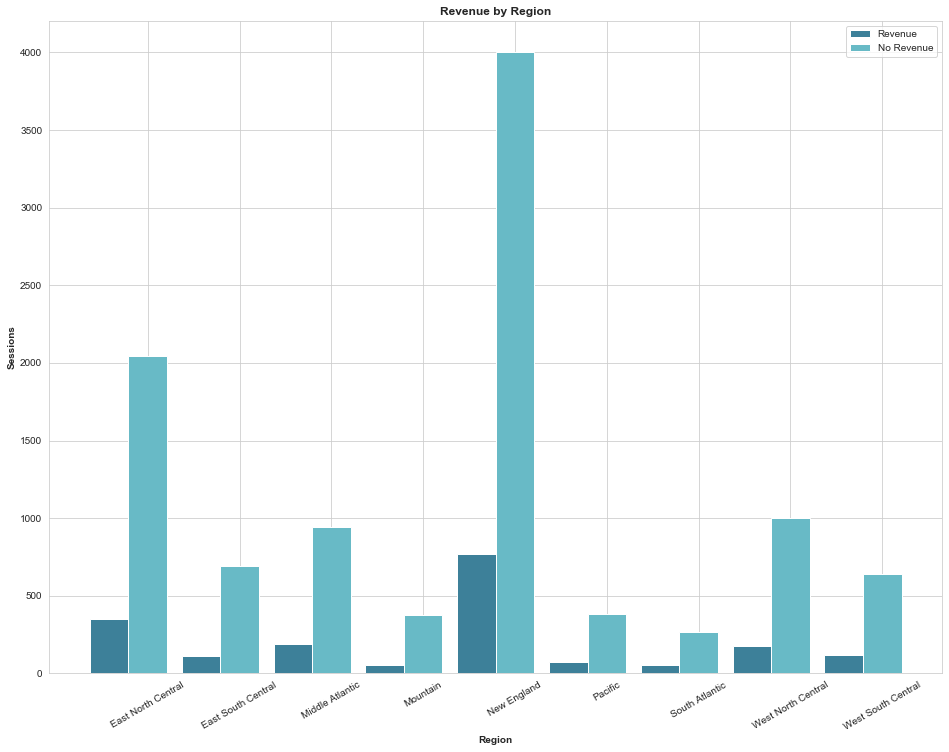

In [229]:
plt.figure(figsize=(16,12))
# set width of bar
barWidth = 0.42
 
# set height of bar
bars1 = regional_revenue[df['Revenue']==True].groupby(['Region']).Revenue.count()
bars2 = regional_revenue[df['Revenue']==False].groupby(['Region']).Revenue.count()
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color=sns.color_palette("GnBu_d",n_colors=2)[0],
        width=barWidth, edgecolor='white', label='Revenue')
plt.bar(r2, bars2, color=sns.color_palette("GnBu_d",n_colors=2)[1],
        width=barWidth, edgecolor='white', label='No Revenue')
 
# Add xticks on the middle of the group bars
plt.xlabel('Region', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))],
           regional_revenue[raw_df['Revenue']==True].groupby(['Region']).Revenue.count().index)
plt.xticks(rotation='30')
plt.ylabel('Sessions', fontweight='bold')
plt.title('Revenue by Region', fontweight='bold')
# Create legend & Show graphic
plt.legend()
plt.show()

In [230]:
regional_revenue.groupby(['Region']).Revenue.count()

Region
East North Central    2395
East South Central     804
Middle Atlantic       1131
Mountain               433
New England           4772
Pacific                456
South Atlantic         318
West North Central    1177
West South Central     759
Name: Revenue, dtype: int64

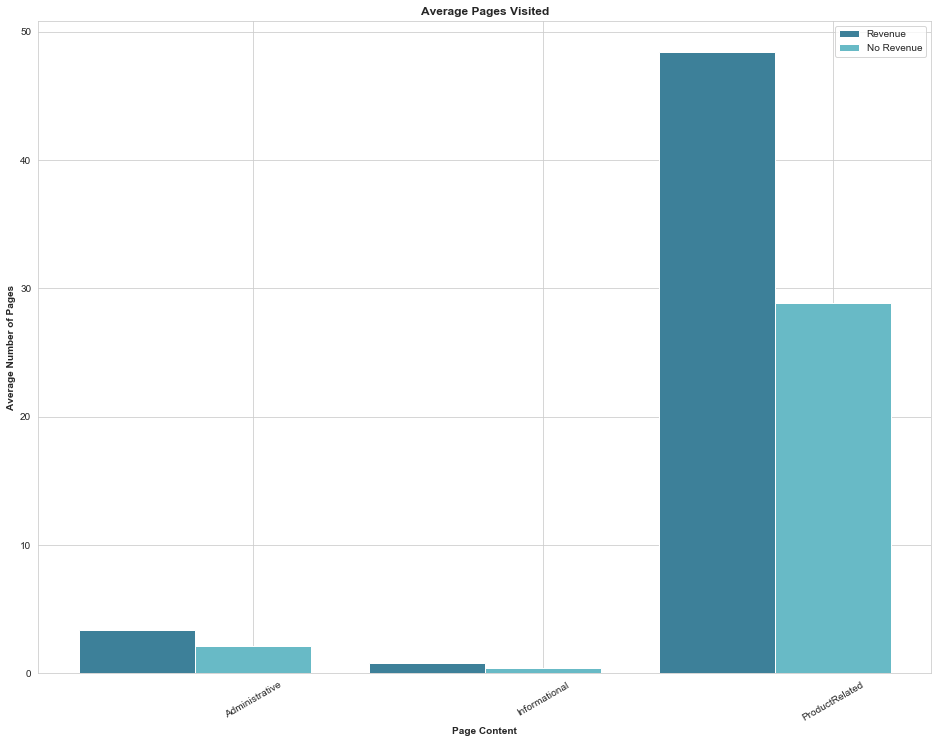

In [231]:
pages = df[['Administrative','Informational', 'ProductRelated','Revenue']].groupby('Revenue').mean()
plt.figure(figsize=(16,12))
# set width of bar
barWidth = 0.40
 
# set height of bar
bars1 = pages.iloc[1]
bars2 = pages.iloc[0]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color=sns.color_palette("GnBu_d",n_colors=2)[0],
        width=barWidth, edgecolor='white', label='Revenue')
plt.bar(r2, bars2, color=sns.color_palette("GnBu_d",n_colors=2)[1],
        width=barWidth, edgecolor='white', label='No Revenue')
 
# Add xticks on the middle of the group bars
plt.xlabel('Page Content', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))],
           pages.iloc[0].index)
plt.xticks(rotation='30')
plt.ylabel('Average Number of Pages', fontweight='bold')
plt.title('Average Pages Visited', fontweight='bold')
# Create legend & Show graphic
plt.legend()
plt.show()

## Feature Engineering

In [232]:
#Create list with categorical features' names.
nonum_feats_names = ['Month', 'OperatingSystems', 'Region', 'Revenue', 
      'SpecialDay', 'TrafficType', 'New_Visitor', 'Weekend']

#Create list with numerical features' names.
num_cols_names = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 
            'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates','PageValues']

In [233]:
#Assign appropriate data type to categorical variables.
nonum_feats = df[nonum_feats_names].astype('category')
nonum_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12245 entries, 0 to 12244
Data columns (total 8 columns):
Month               12245 non-null category
OperatingSystems    12245 non-null category
Region              12245 non-null category
Revenue             12245 non-null category
SpecialDay          12245 non-null category
TrafficType         12245 non-null category
New_Visitor         12245 non-null category
Weekend             12245 non-null category
dtypes: category(8)
memory usage: 98.2 KB


In [234]:
#One-hot-code categorical variables and dropping the reference value.
ohc_feats = pd.get_dummies(nonum_feats,drop_first=True)
ohc_feats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12245 entries, 0 to 12244
Data columns (total 51 columns):
Month_3               12245 non-null uint8
Month_5               12245 non-null uint8
Month_6               12245 non-null uint8
Month_7               12245 non-null uint8
Month_8               12245 non-null uint8
Month_9               12245 non-null uint8
Month_10              12245 non-null uint8
Month_11              12245 non-null uint8
Month_12              12245 non-null uint8
OperatingSystems_2    12245 non-null uint8
OperatingSystems_3    12245 non-null uint8
OperatingSystems_4    12245 non-null uint8
OperatingSystems_5    12245 non-null uint8
OperatingSystems_6    12245 non-null uint8
OperatingSystems_7    12245 non-null uint8
OperatingSystems_8    12245 non-null uint8
Region_2              12245 non-null uint8
Region_3              12245 non-null uint8
Region_4              12245 non-null uint8
Region_5              12245 non-null uint8
Region_6              12245 non

## Feature Distribution

In [235]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(3,3,figsize=(22,26))

    for feature in features:
        i += 1
        plt.subplot(3,3,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

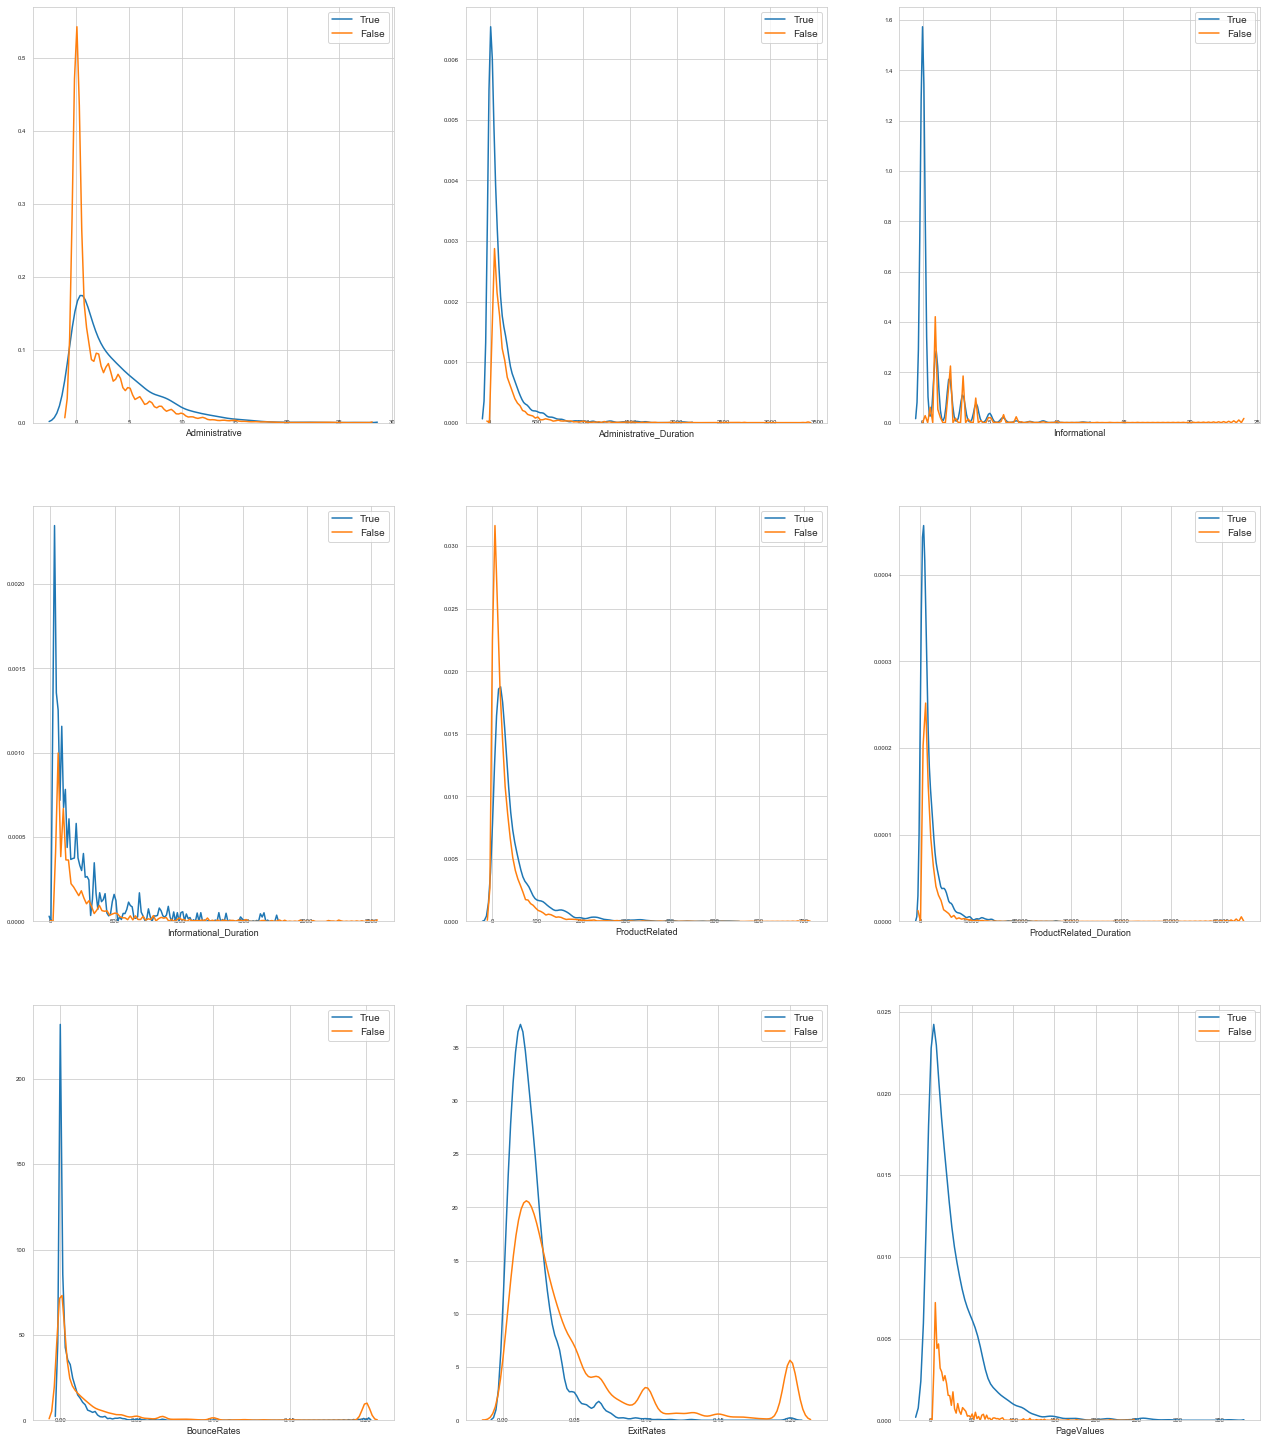

In [236]:
t0 = df.loc[df['Revenue'] == True]
t1 = df.loc[df['Revenue'] == False]
features = df.columns.values[0:9]
plot_feature_distribution(t0, t1, 'True', 'False', features)

# MODELLING

In [237]:
skf = StratifiedKFold(n_splits=5)

In [238]:
class Classification():
    
    def __init__(self, model, x_train, x_val, y_train, y_val):
        self.model = model
        self.x_train = x_train
        self.x_val = x_val
        self.y_train = y_train
        self.y_val = y_val
        self.scores_table = pd.DataFrame()
        
        if self.model == 'Decision Tree':
            self.fitting = DecisionTreeClassifier(random_state = 42)
        elif self.model == 'Random Forest':
            self.fitting = RandomForestClassifier(n_estimators = 10, 
                                                    n_jobs = -1, random_state=42)
        elif self.model == 'Logistic Regression':
            self.fitting = LogisticRegression(fit_intercept = True)
#         elif SVM
#         elif Naive Bayes

            
    def scores(self,model,X_train,X_val,y_train,y_val):
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]

        auc_train = roc_auc_score(y_train,train_prob)
        auc_val = roc_auc_score(y_val,val_prob)

        self.auc_train = auc_train
        self.auc_val = auc_val

        self.scores_table["Model Name"] = [self.model]
        self.scores_table["Train AUC"] = [self.auc_train]
        self.scores_table["Validation AUC"] = [self.auc_val]

        return self.scores_table


    def annot(fpr,tpr,thr):
        k=0
        for i,j in zip(fpr,tpr):
            if k %50 == 0:
                plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
            k+=1
    
    
    def roc_plot(model,X_train,X_val,y_train,y_val):
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        plt.figure(figsize=(7,7))
        for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
            fpr, tpr, threshold = roc_curve(data[0], data[1])
            plt.plot(fpr, tpr)
        Classification.annot(fpr, tpr, threshold)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('TPR (power)')
        plt.xlabel('FPR (alpha)')
        plt.legend(['train','val'])
        plt.show()
        

    def get_scores(self,param_grid,cv_type):
        reg = self.fitting
        fit_reg = reg.fit(self.x_train,self.y_train)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.x_train,self.y_train) 
        self.best_model = opt_model.best_estimator_
        self.scores = Classification.scores(self,self.best_model,
                                            self.x_train,self.x_val,
                                            self.y_train,self.y_val)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        print("The best hyperparameters are: ", self.best_params,'\n')
        self.roc_plot = Classification.roc_plot(self.best_model,
                                                self.x_train,self.x_val,
                                                self.y_train,self.y_val)
        self.y_tested = opt_model.predict(self.x_val)
        
        
    def opt_plots(self):
        if self.model == "Decision Tree" or self.model == "Random Forest":
            opt = pd.DataFrame(self.opt_model.cv_results_)
            cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
            params = pd.DataFrame(list(opt.params))
            opt = pd.concat([params,opt[cols]],axis=1,sort=False)

            plt.figure(figsize=[15,4])
            plt.subplot(121)
            sns.heatmap(pd.pivot_table(opt,index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_train_score')*100)
            plt.title('ROC_AUC - Training')
            plt.subplot(122)
            sns.heatmap(pd.pivot_table(opt,index='max_depth',
                                       columns='min_samples_leaf',
                                       values='mean_test_score')*100)
            plt.title('ROC_AUC - Validation')
        else:
            print("This model does not have an optimum hyperparameter plot!")
            
            
    def conf_matrix(y_true, y_pred):
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}

        for ind, label in enumerate(y_true):
            pred = y_pred[ind]
            if label == 1: 
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1

        return cm
    
    
    def show_conf_matrix(self):
        Classification.conf_matrix(self.y_val, self.y_tested)
        cnf_matrix = confusion_matrix(self.y_val, self.y_tested)

        plt.figure(figsize=(7,7))
        plt.imshow(cnf_matrix,  cmap=plt.cm.Blues)

        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        class_names = set(y)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar
        
        
    def plot_decision_tree(self):
        if self.model == "Decision Tree":
            plt.figure(figsize=(22,22))
            tree.plot_tree(self.best_model.fit(self.x_train,self.y_train))
        else:
            print("This model does not have a decision tree plot!")
            
            
    def threshold_selection(self, prevalence, CostFP_minus_CostTN, CostFN_minus_CostTP, y_train, y_test):
        fpr, tpr, thresholds = roc_curve(self.y_train, self.y_test)
        m = ((1 - prevalence) / prevalence) * ((CostFP_minus_CostTN) / (CostFN_minus_CostTP))
        fm_thresholds = []
        for i in range(len(fpr)):
            fm = tpr[i] - (m * fpr[i])
            fm_thresholds.append((thresholds[i], fm))
        fm_thresholds = sorted(fm_thresholds, key=lambda fm_value: fm_value[1], reverse=True)
        return fm_thresholds[0][0]




In [239]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=.25, random_state=42)

X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42)


## Logistic Regression

In [240]:
scaler = preprocessing.StandardScaler()
X_train_v_scaled = scaler.fit_transform(X_train_v)
X_val_scaled = scaler.transform(X_val)

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.912969,0.920746


The best hyperparameters are:  {'C': 0.5, 'penalty': 'l1', 'solver': 'saga'} 



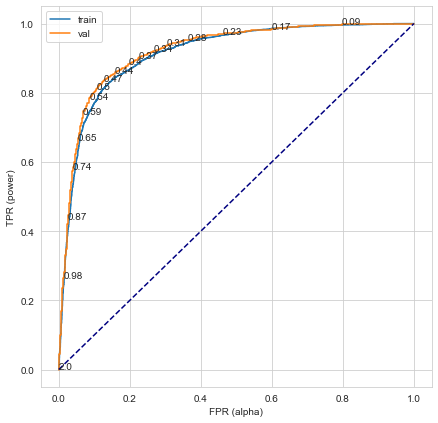

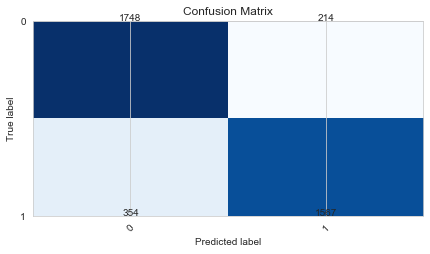

In [241]:
logistic = Classification('Logistic Regression', X_train_v_scaled, X_val_scaled, y_train_v, y_val)

param_grid = {"penalty":['l1', 'l2', 'elasticnet', 'none'],            # l1 and l2 are different type of penalties
              "solver" : ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
              "C":[0.5, 1, 5]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization
# param_grid = {}

logistic.get_scores(param_grid,skf)
logistic.show_conf_matrix()

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.913272,0.920823


The best hyperparameters are:  {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'} 



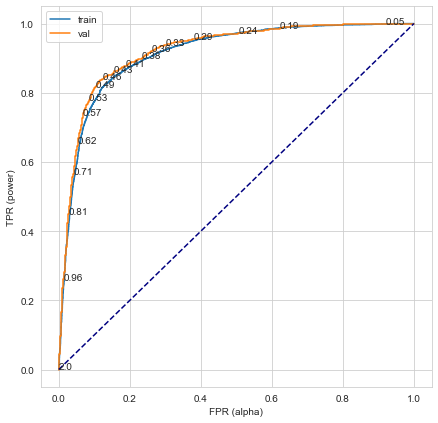

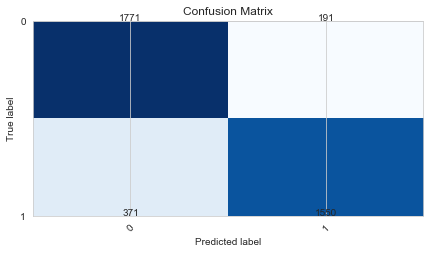

In [242]:
logistic = Classification('Logistic Regression', X_train_v_scaled, X_val_scaled, y_train_v, y_val)

param_grid = {"penalty":['l1'],            # l1 and l2 are different type of penalties
              "solver" : ['saga'],  # Algorithm to use in the optimization problem
              "C":[0.005, 0.01, 0.2, 0.3, 0.4, 0.5, 0.6]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization
# param_grid = {}

logistic.get_scores(param_grid,skf)
logistic.show_conf_matrix()

,Model Name,Train AUC,Validation AUC
0,Logistic Regression,0.913272,0.920823


The best hyperparameters are:  {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'} 



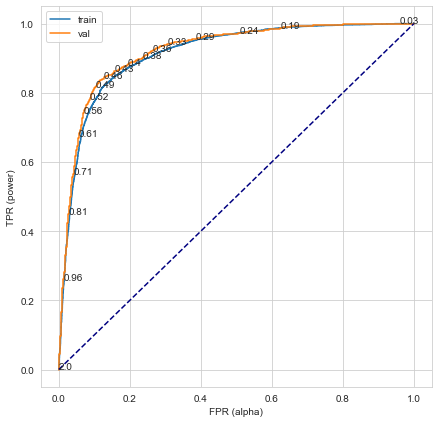

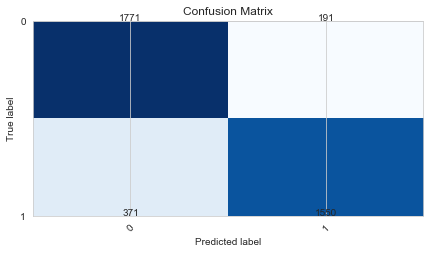

In [243]:
logistic = Classification('Logistic Regression', X_train_v_scaled, X_val_scaled, y_train_v, y_val)

param_grid = {"penalty":['l1'],            # l1 and l2 are different type of penalties
              "solver" : ['saga'],  # Algorithm to use in the optimization problem
              "C":[0.005, 0.0075, 0.01, 0.0125, 0.015]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization
# param_grid = {}

logistic.get_scores(param_grid,skf)
logistic.show_conf_matrix()

## Decision Tree

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.964142,0.958766


The best hyperparameters are:  {'max_depth': 10, 'min_samples_leaf': 100} 



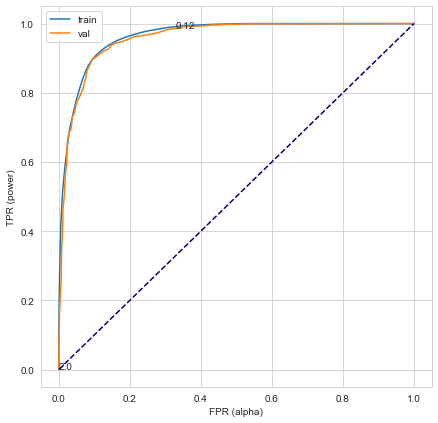

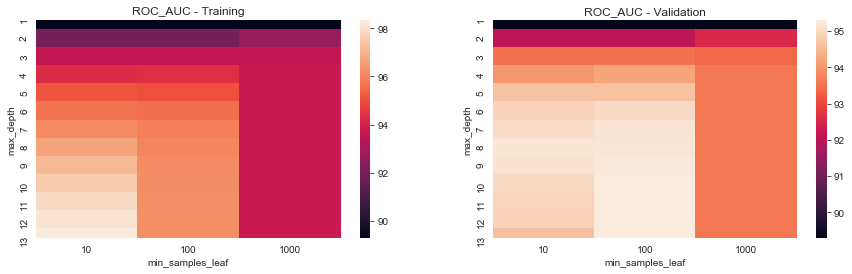

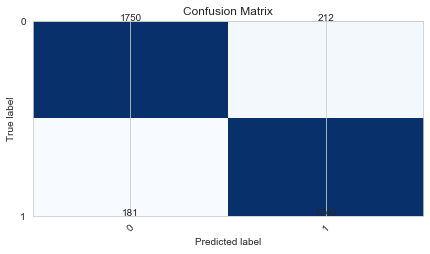

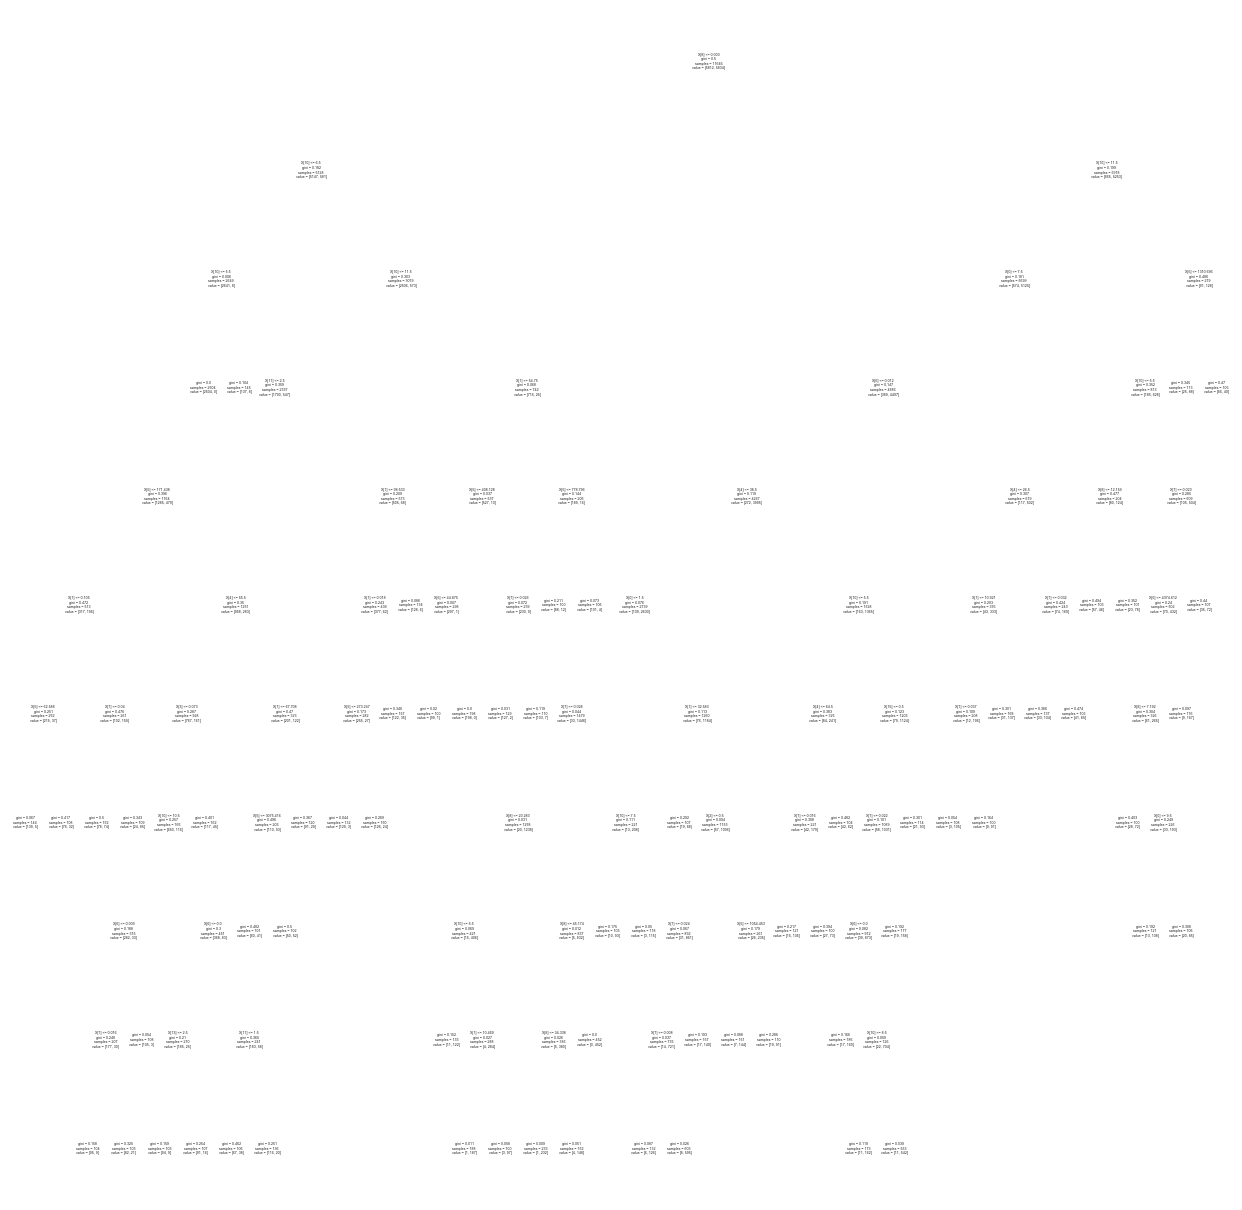

In [244]:
dtree = Classification('Decision Tree', X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],                 # The maximum depth of the tree
              'min_samples_leaf':[10, 100, 1000]}  # The minimum number of samples required to be at a leaf node

dtree.get_scores(param_grid,skf)
dtree.opt_plots()
dtree.show_conf_matrix()
dtree.plot_decision_tree()

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.968025,0.960114


The best hyperparameters are:  {'max_depth': 9, 'min_samples_leaf': 50} 



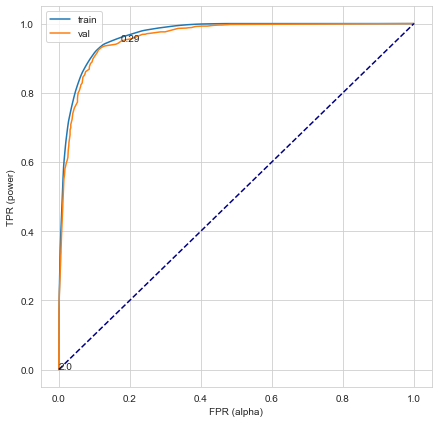

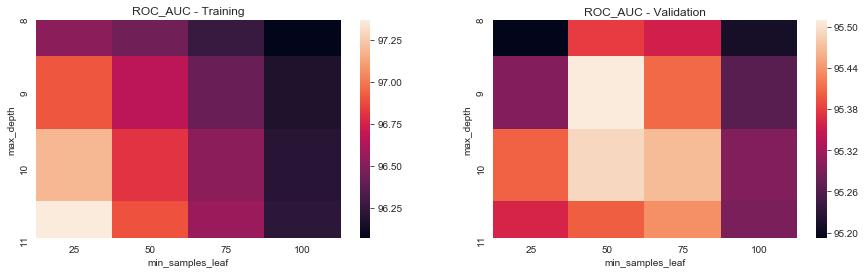

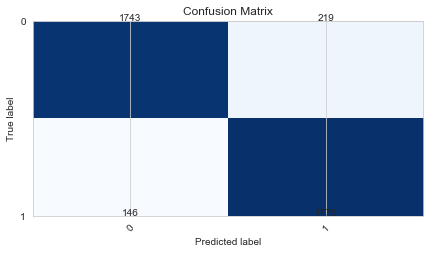

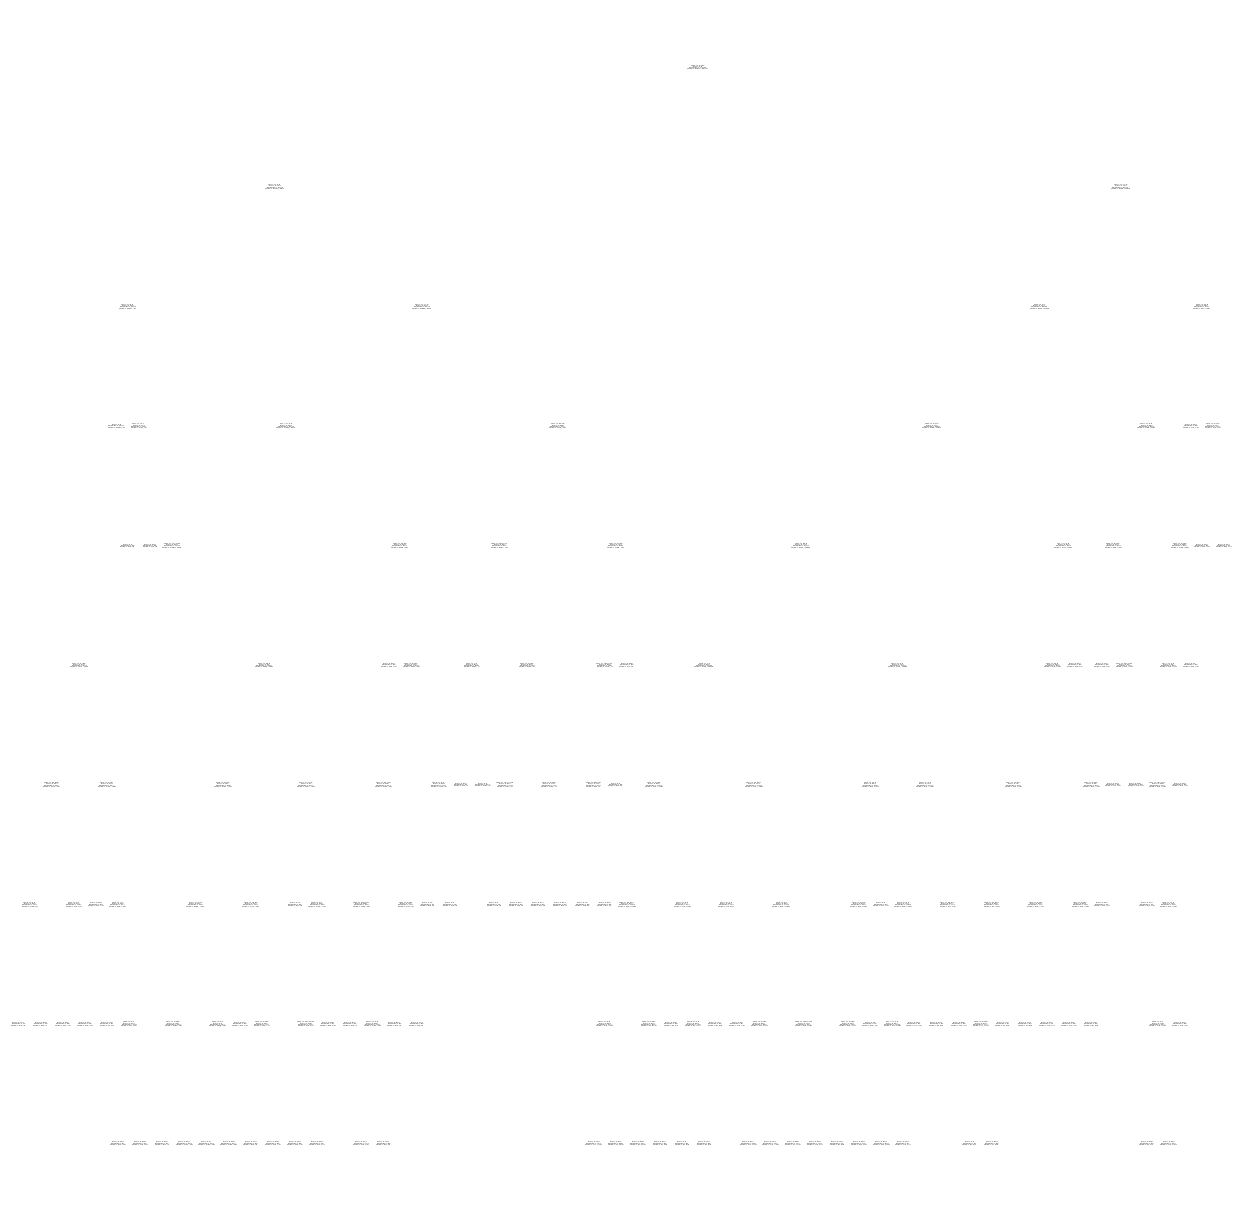

In [245]:
dtree = Classification('Decision Tree', X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[8, 9, 10, 11],                 # The maximum depth of the tree
              'min_samples_leaf':[25, 50, 75, 100]}  # The minimum number of samples required to be at a leaf node

dtree.get_scores(param_grid,skf)
dtree.opt_plots()
dtree.show_conf_matrix()
dtree.plot_decision_tree()

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.966777,0.960459


The best hyperparameters are:  {'max_depth': 9, 'min_samples_leaf': 65} 



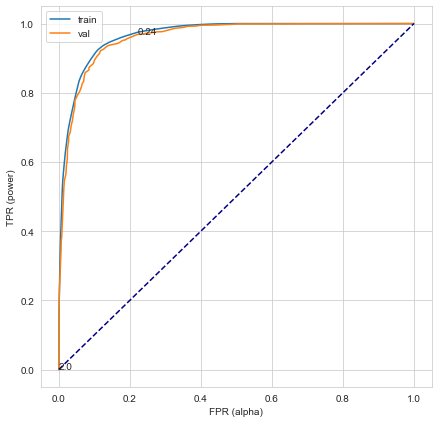

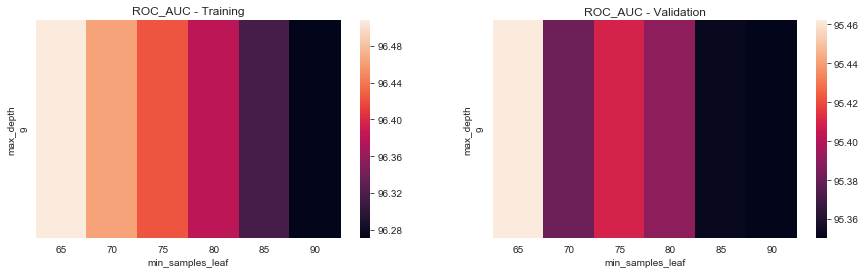

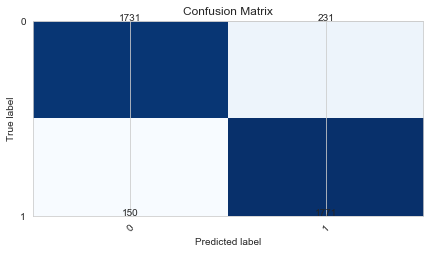

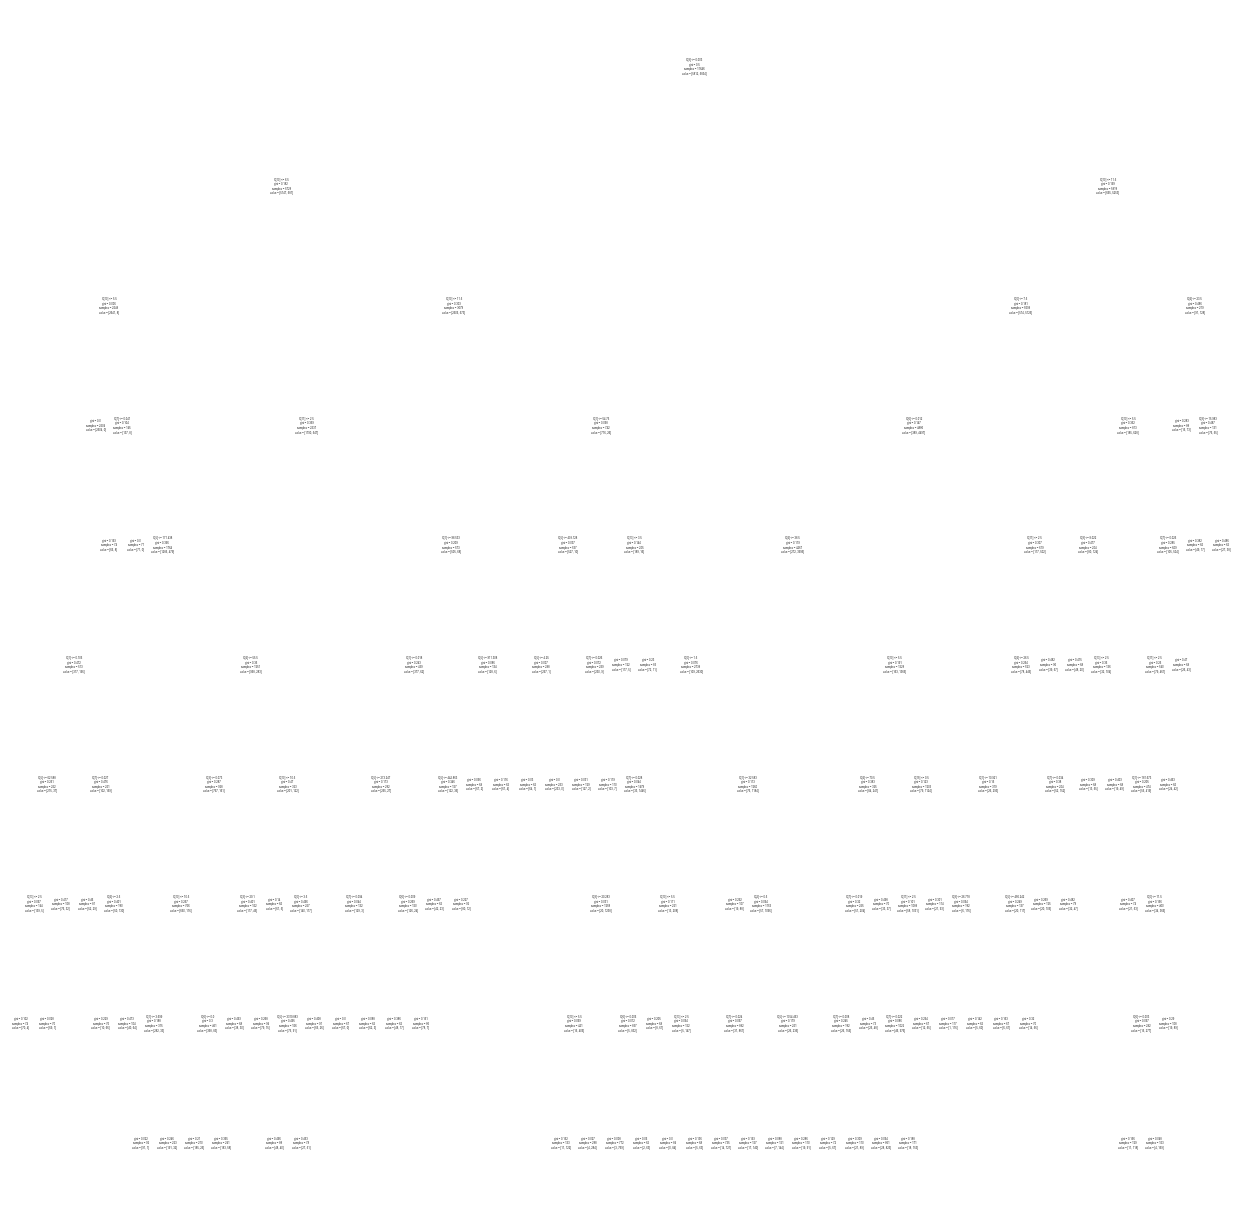

In [246]:
dtree = Classification('Decision Tree', X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[9],                 # The maximum depth of the tree
              'min_samples_leaf':[65, 70, 75, 80, 85, 90]}  # The minimum number of samples required to be at a leaf node

dtree.get_scores(param_grid,skf)
dtree.opt_plots()
dtree.show_conf_matrix()
dtree.plot_decision_tree()

## K Nearest Naighbors

In [247]:
min_k=1
max_k=25
best_k = 0
best_score = 0.0
for k in range(min_k, max_k+1, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_v, y_train_v)
    preds = knn.predict(X_val)
    f1 = f1_score(y_val, preds)
    if f1 > best_score:
        best_k = k
        best_score = f1
best_k

1

[[1586  376]
 [  92 1829]]


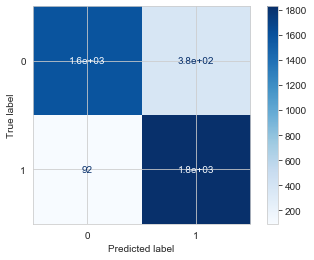

In [248]:
knn = KNeighborsClassifier(n_neighbors = 1)

knnfit = knn.fit(X_train_v, y_train_v)
y_pred = knn.predict(X_train_v)
# confmatrix = plot_confusion_matrix(knnfit, X_val, y_val)
disp = plot_confusion_matrix(knnfit, X_val, y_val,
                             cmap=plt.cm.Blues)

print(disp.confusion_matrix)

plt.show()

## Random Forest

,Model Name,Train AUC,Validation AUC
0,Random Forest,0.997233,0.969447


The best hyperparameters are:  {'max_depth': 15, 'min_samples_leaf': 1} 



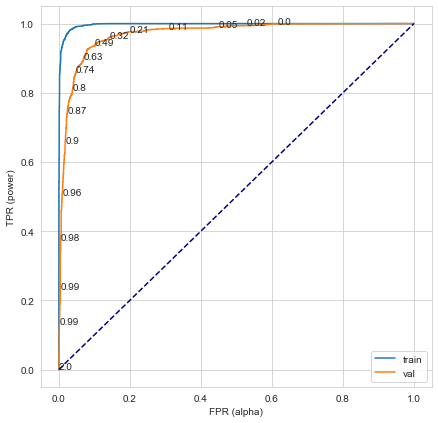

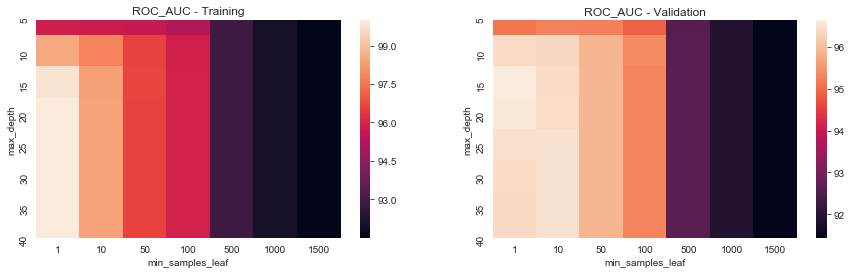

In [249]:
ran_forest = Classification('Random Forest',X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[5,10,15,20,25,30,35,40],           # The maximum depth of the tree
              'min_samples_leaf':[1,10,50,100,500,1000,1500]} # The minimum number of samples required to be at a leaf node

ran_forest.get_scores(param_grid,skf)
ran_forest.opt_plots()

,Model Name,Train AUC,Validation AUC
0,Random Forest,0.993751,0.971798


The best hyperparameters are:  {'max_depth': 15, 'min_samples_leaf': 3} 



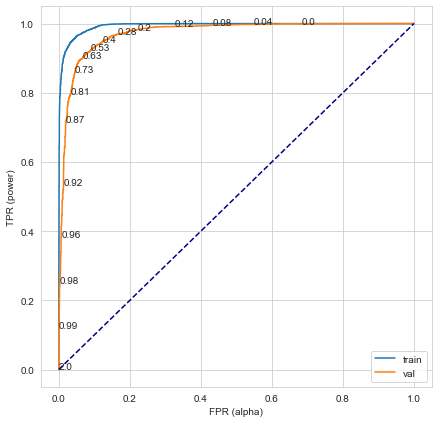

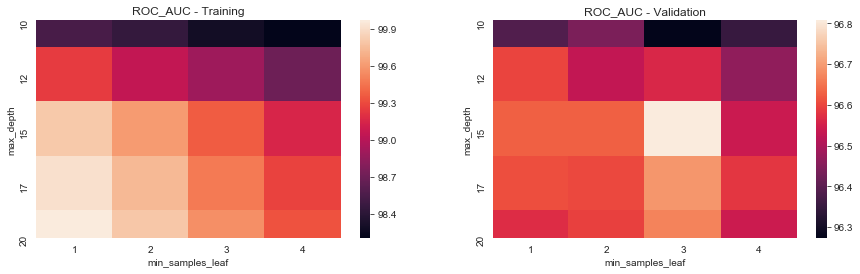

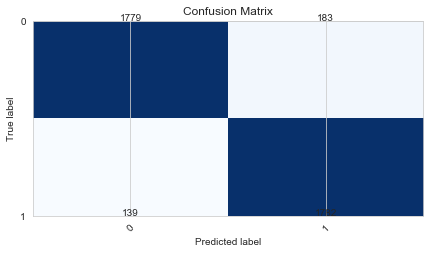

In [250]:
ran_forest = Classification('Random Forest',X_train_v, X_val, y_train_v, y_val)

param_grid = {'max_depth':[10, 12, 15, 17, 20],           # The maximum depth of the tree
              'min_samples_leaf':[1, 2, 3, 4]} # The minimum number of samples required to be at a leaf node

ran_forest.get_scores(param_grid,skf)
ran_forest.opt_plots()
ran_forest.show_conf_matrix()


## Stacking with XGBoost

In [269]:
models = [
    RandomForestClassifier(n_estimators = 10, max_depth = 15, 
                           min_samples_leaf = 3,
                           n_jobs = -1, random_state=42),
          knn,
          DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 150, random_state = 42)
]

In [270]:
S_train, S_test = stacking(models,                   
                           X_train_v, y_train_v, X_val,   
                           regression=False, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=roc_auc_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=42,
                          
                           verbose = 2)

task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [RandomForestClassifier]
    fold  0:  [0.91825898]
    fold  1:  [0.91688959]
    fold  2:  [0.91374381]
    fold  3:  [0.90618153]
    ----
    MEAN:     [0.91376848] + [0.00467623]
    FULL:     [0.91376777]

model  1:     [KNeighborsClassifier]
    fold  0:  [0.87419378]
    fold  1:  [0.88175866]
    fold  2:  [0.86659879]
    fold  3:  [0.85940068]
    ----
    MEAN:     [0.87048798] + [0.00834888]
    FULL:     [0.87048875]

model  2:     [DecisionTreeClassifier]
    fold  0:  [0.90207705]
    fold  1:  [0.89556008]
    fold  2:  [0.89893976]
    fold  3:  [0.88897692]
    ----
    MEAN:     [0.89638845] + [0.00486020]
    FULL:     [0.89638766]



In [271]:
model = XGBClassifier(random_state=42, n_jobs=-1, learning_rate=0.5, 
                      n_estimators=100, max_depth=3)
    
model = model.fit(S_train, y_train_v)
y_pred = model.predict(S_test)

print('Final prediction score: [%.8f]' % roc_auc_score(y_val, y_pred))

Final prediction score: [0.91447948]


## Threshold Selection

Our Random Forest Classifier was our best performing model when using the ROC AUC metric to compare our models. KNN models don't have ROC curves so we have to take a more nuaced approach when comparing it to our other models. Whilst the KNN model was our best performer in terms of least False Negatives, it uses a K=1 hyperparameter when optimised to our training data. Consequently we don't believe our KNN's results to be reproducable on other data so we disgarded it.

In [272]:
final = RandomForestClassifier(n_estimators = 10, max_depth = 15, 
                           min_samples_leaf = 3,
                           n_jobs = -1, random_state=42)
model = final.fit(X_train_v, y_train_v)

In [273]:
val_prob = model.predict_proba(X_val)[:,1]

In [274]:
fpr, tpr, thresh = roc_curve(y_val, val_prob)

In [275]:
df_t = pd.DataFrame()
df_t['fpr'] = fpr
df_t['tpr'] = tpr
df_t['thresh'] = thresh

In [276]:
fp = 1
tn = 0

fn = 10
tp = -5
prevalence = df['Revenue'].sum()/df.shape[0]

In [277]:
m = ((1 - prevalence) / prevalence) * ((fp-tn) / (fn-tp))

In [278]:
for i in df_t.index:
    df_t.loc[i, 'fm'] = df_t.loc[i, 'tpr'] - (m * df_t.loc[i, 'fpr'])

In [279]:
df_t.sort_values(by='fm', ascending=False, inplace=True)
df_t.head()

,fpr,tpr,thresh,fm
536,0.152905,0.966163,0.303697,0.910384
532,0.145260,0.963040,0.317857,0.910049
534,0.148318,0.964081,0.313773,0.909975
546,0.162589,0.968766,0.280998,0.909454
544,0.161570,0.968246,0.285820,0.909305


In [287]:
threshold = 0.303697

In [288]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [289]:
predicted_proba = model.predict_proba(X_test)
predicted = (predicted_proba[:,1] >= threshold).astype('int')

In [290]:
unique, counts = np.unique(predicted, return_counts=True)
dict(zip(unique, counts))

{0: 2280, 1: 2897}

In [291]:
def conf_matrix(y_true, y_pred):
        
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
        
        for i, label in enumerate(y_true):
            
            pred = y_pred[i]
            if label == 1:
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1
                
        return cm

In [292]:
def plot_conf_matrix(y_true, y_predicted):
        
        cnf_matrix = confusion_matrix(y_true, predicted)
        
        plt.figure(figsize=(8,18))
        plt.imshow(cnf_matrix, cmap=plt.cm.Greens)
        
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        class_names = set(y)
        tick_marks = np.arange(1,2,1)
        plt.xticks(tick_marks, [1,0], rotation=45)
        plt.yticks(tick_marks, [1,0])

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar

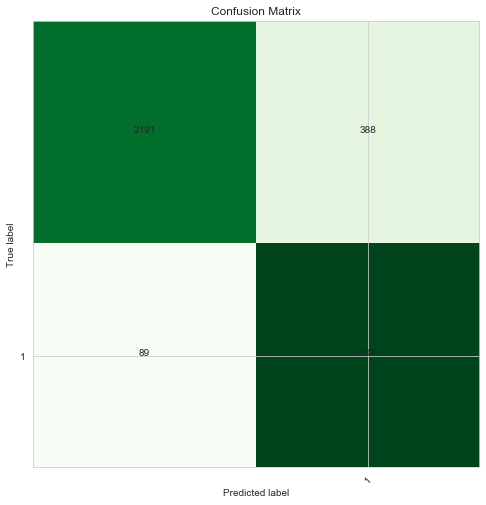

In [293]:
plot_conf_matrix(y_test, predicted)

In [295]:
model.feature_importances_

array([0.02136582, 0.05498822, 0.00736032, 0.01172088, 0.04121552,
       0.05269293, 0.03675193, 0.08399174, 0.54999715, 0.00328441,
       0.06962426, 0.02052477, 0.00857853, 0.01467066, 0.01404439,
       0.00918846])